In [3]:
import pandas as pd

In [4]:
# Load data
file_path = "data/redlat.genes.chr.counts.hg38_multianno.tsv"
original_df = pd.read_csv(file_path, sep='\t')

# Filter data we care about 
df = original_df[
    (original_df["Func.refGene"] == "exonic") & 
    (original_df["ExonicFunc.refGene"] == "nonsynonymous SNV")
]

In [ ]:
# Verify filtering worked
df["AAChange.refGene"].head()

45       TARDBP:NM_007375:exon2:c.G149C:p.C50S
323     TARDBP:NM_007375:exon6:c.A776G:p.N259S
324     TARDBP:NM_007375:exon6:c.G881T:p.G294V
326    TARDBP:NM_007375:exon6:c.A1147G:p.I383V
327    TARDBP:NM_007375:exon6:c.G1154T:p.W385L
Name: AAChange.refGene, dtype: object

In [5]:
desired_isoforms = {
    "PSEN1": "NM_000021",
    "PSEN2": "NM_000447",
    "TARDBP": "NM_007375",
    "MAPT": "NM_005910"
}

In [6]:
# Let's parse all the rows and select the correct variant name
# It will be in the AAChange.refGene column, but there is a lot of fields to parse

def extract_variant(row):
    isoforms = row["AAChange.refGene"].split(",")
    all_affected = row["All_affected"]
    all_unaffected = row["All_unaffected"]

    case_cnt = int(all_affected.split("/")[1])
    control_cnt = int(all_unaffected.split("/")[1])
    
    for isoform in isoforms:
        parts = isoform.split(":")
        if len(parts) < 4:
            continue  # Skip malformed entries

        gene_name, isoform_id = parts[0], parts[1]

        if gene_name not in desired_isoforms:
            continue  # Skip unknown gene names

        if desired_isoforms[gene_name] == isoform_id:
            aavariant = parts[-1][2:]  # Extract amino acid variant
            aa_number = aavariant[1:-1] if len(aavariant) > 2 else ""  # Extract the inner number
            return pd.Series([aavariant, aa_number, case_cnt, control_cnt])

    return pd.Series([None, None, 0, 0])  # Return None if no match found

df[["variant", "AA", "case", "control"]] = df.apply(extract_variant, axis=1)
df = df.dropna(subset=["AA"])
df["case"] = df["case"].astype(int)
df["control"] = df["control"].astype(int)


/var/folders/5n/gkdqz59j4x5c3d4g045zn_n40000gn/T/ipykernel_69457/2832611794.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["variant", "AA", "case", "control"]] = df.apply(extract_variant, axis=1)
/var/folders/5n/gkdqz59j4x5c3d4g045zn_n40000gn/T/ipykernel_69457/2832611794.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["variant", "AA", "case", "control"]] = df.apply(extract_variant, axis=1)
/var/folders/5n/gkdqz59j4x5c3d4g045zn_n40000gn/T/ipykernel_69457/2832611794.py:29: SettingWithCopyWa

In [ ]:
# Now export the selected columns
for gene in desired_isoforms.keys():
    filtered_df = df[df["Gene.refGene"] == gene][["Gene.refGene", "AA", "variant", "case", "control"]]
    file_name = f"output/{gene}.txt"
    filtered_df.to_csv(file_name, index=False, sep='\t')

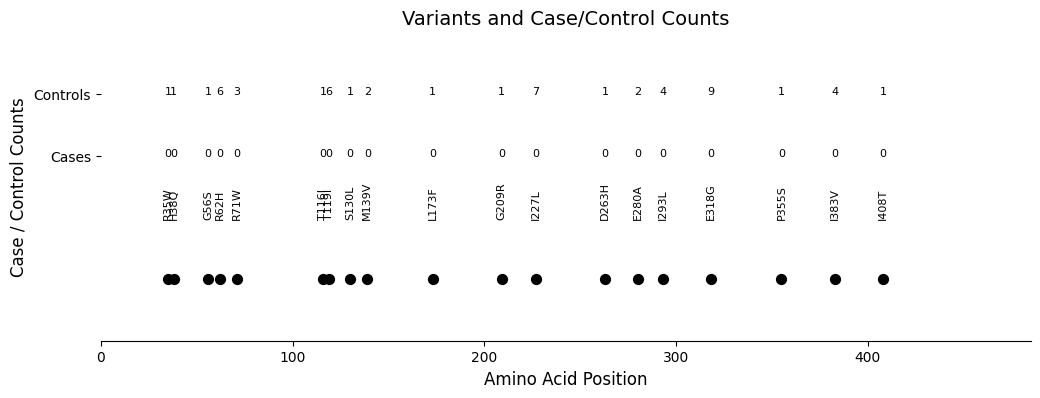

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the variants data
variants = pd.read_csv("variants.txt", sep="\t")  # Adjust separator if needed

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 4))

# Scatter plot for variants
for _, row in variants.iterrows():
    color = "crimson" if row["control"] == 0 else "black"
    if row["case"] == 0 and row["control"] == 0:
        continue

    ax.scatter(row["AA"], 0, color=color, s=50)  # Plot variant position
    ax.text(row["AA"], 0.05, row["variant"], rotation=90, ha="center", fontsize=8, color=color)  # Label variants
    ax.text(row["AA"], 0.1, str(row["case"]), ha="center", fontsize=8, color=color)
    ax.text(row["AA"], 0.15, str(row["control"]), ha="center", fontsize=8, color=color)

# Formatting
ax.set_xlim(0, variants["AA"].max() + 50)  # Adjust x-axis based on data
ax.set_ylim(-0.05, 0.2)
ax.set_xlabel("Amino Acid Position", fontsize=12)
ax.set_ylabel("Case / Control Counts", fontsize=12)  # Add y-axis label
ax.set_yticks([0.1, 0.15])
ax.set_yticklabels(["Cases", "Controls"], fontsize=10)  # Label y-axis ticks

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.title("Variants and Case/Control Counts", fontsize=14)
plt.show()


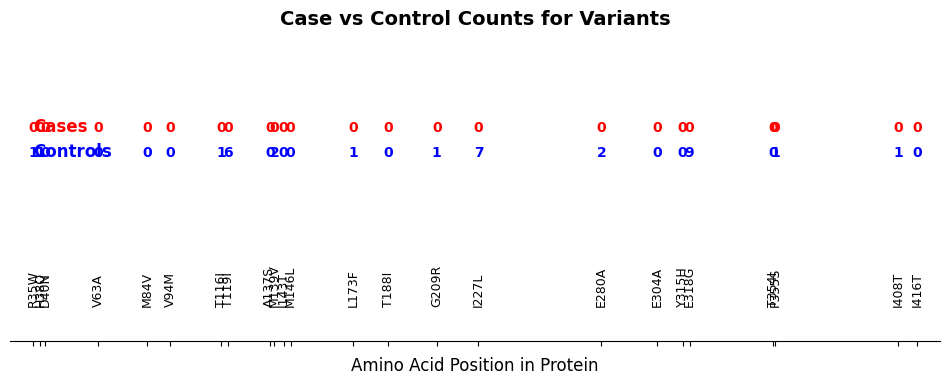

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
file_path = "output/PSEN1.txt"  # Change this to your actual file
df = pd.read_csv(file_path, sep="\t", dtype={"AA": str})  # Ensure AA is a string

# Extract numeric amino acid index
df["Amino_Acid_Index"] = df["AA"].str.extract(r'(\d+)').astype(int)

# Sort by Amino Acid Index for better visualization
df = df.sort_values(by="Amino_Acid_Index")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Plot cases and controls above the variant position
for index, row in df.iterrows():
    x = row["Amino_Acid_Index"]
    case_count = row["case"]
    control_count = row["control"]
    
    # Add case & control numbers above the variant
    ax.text(x, 1.2, f"{case_count}", color="red", fontsize=10, ha="center", fontweight="bold")
    ax.text(x, 1.0, f"{control_count}", color="blue", fontsize=10, ha="center", fontweight="bold")
    
    # Add variant label below the axis
    ax.text(x, -0.2, row["variant"], fontsize=9, ha="center", rotation=90, color="black")

# Set axis limits and labels
ax.set_xlim(df["Amino_Acid_Index"].min() - 10, df["Amino_Acid_Index"].max() + 10)
ax.set_ylim(-0.5, 2)
ax.set_xticks(df["Amino_Acid_Index"])
ax.set_xticklabels([])  # Hide tick labels since we use variant names instead
ax.set_yticks([])
ax.set_xlabel("Amino Acid Position in Protein", fontsize=12)
ax.set_title("Case vs Control Counts for Variants", fontsize=14, fontweight="bold")

# Add legend
ax.text(df["Amino_Acid_Index"].min(), 1.2, "Cases", color="red", fontsize=12, fontweight="bold")
ax.text(df["Amino_Acid_Index"].min(), 1.0, "Controls", color="blue", fontsize=12, fontweight="bold")

# Hide spines
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()